Amir Mobayen
Deep Learning Final Exam

For the both networks, you should:
- **Create a test and validation set**
- **Preprocess the data**: While preprocessing is not the subject of this exam,wrong/poor preprocessing steps will be sanctioned.
- **Explain all of your choices with comments**: Why did you choose this preprocessing ? this architecture ? this hyperparameter ?
- **Compare different architectures**: Layer hyperparameters (activation function,initialization method, units), regularization methods (dropout, batch normalization, l1 l2 regularization, early stopping …), training hyperparameters (learning rate, batch size, optimizers …) …
- **Train the model and evaluate its performances on the test set**: The results should be shown in the Notebook.

Your project should be returned as a Notebook. No ZIP file.
**(Bonus Point)** Save your model.

In [1]:
import matplotlib.pyplot as plt
# Basic packages
import numpy as np
import pandas as pd
import os
import random

# Tensorflow
import tensorflow as tf
from numpy import ravel
from sklearn.compose import ColumnTransformer
# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error
from PIL import Image, ImageOps
import pathlib


2023-06-22 12:19:11.900625: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Part One (Training On RNN)
- The Trip Advisor DataSet
- The Global Temperature DataSet

In [2]:
data = pd.read_csv('data/Global_Temperatures.csv', index_col=0)
data.describe(), data.head()

(       LandAverageTemperature
 count             3159.000000
 mean                 8.377803
 std                  4.378687
 min                 -2.080000
 25%                  4.318500
 50%                  8.618000
 75%                 12.548500
 max                 19.021000,
            dt  LandAverageTemperature
 0  1752-10-01                   7.839
 1  1752-11-01                   7.335
 2  1752-12-01                   5.086
 3  1753-01-01                   2.039
 4  1753-02-01                   0.715)

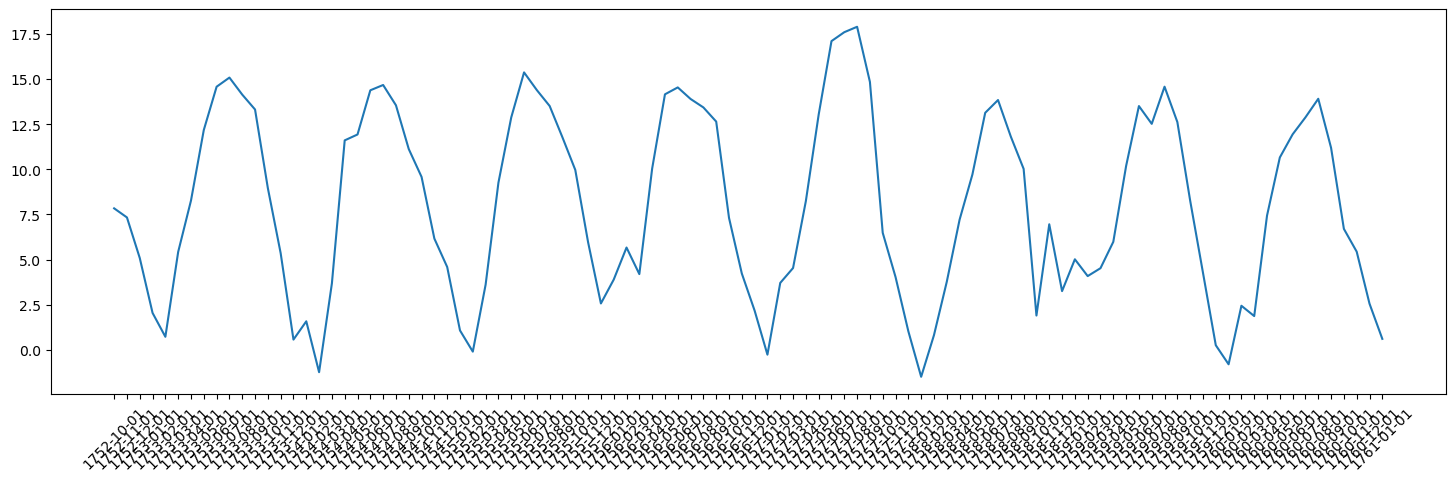

In [3]:
sample = data.head((100))
plt.figure(1, figsize=(18, 5))
plt.plot(sample['dt'], sample['LandAverageTemperature'])
plt.xticks(rotation=45)
plt.show()

In [4]:
# make a copy in order not to touch the original file
data_set = data.copy()

# make sure about data type:
data_set['dt'] = pd.to_datetime(data_set['dt'], infer_datetime_format=True)

# clean input data:
# remove null values on numerical columns
data_set = data_set.dropna()

# remove duplicates
data_set = data_set.drop_duplicates()

# data_set = data_set.to_numpy(dtype=float)
data_set

,dt,LandAverageTemperature
0,1752-10-01,7.839
1,1752-11-01,7.335
2,1752-12-01,5.086
3,1753-01-01,2.039
4,1753-02-01,0.715
...,...,...
3154,2015-08-01,14.755
3155,2015-09-01,12.999
3156,2015-10-01,10.801
3157,2015-11-01,7.433


In [5]:
def prep_data(datain, time_step):
    # 1. y-array
    # First, create an array with indices for y elements based on the chosen time_step
    y_indices = np.arange(start=time_step, stop=len(datain), step=time_step)
    # Create y array based on the above indices
    y_tmp = datain[y_indices]

    # 2. X-array
    # We want to have the same number of rows for X as we do for y
    rows_X = len(y_tmp)
    # Since the last element in y_tmp may not be the last element of the datain,
    # let's ensure that X array stops with the last y
    X_tmp = datain[range(time_step * rows_X)]
    # Now take this array and reshape it into the desired shape
    X_tmp = np.reshape(X_tmp, (rows_X, time_step, 1))
    return X_tmp, y_tmp


def reset_seeds():
    os.environ['PYTHONHASHSEED'] = str(2)
    tf.random.set_seed(2)
    np.random.seed(2)
    random.seed(2)

In [6]:
# Normalize Data
scaler = StandardScaler()
X = data_set[['LandAverageTemperature']]
X_scaled = scaler.fit_transform(X)

train_data, test_data = train_test_split(X_scaled, test_size=0.2, shuffle=False)
train_data, val_data = train_test_split(train_data, test_size=0.2, shuffle=False)

time_step = 7
X_train, y_train = prep_data(train_data, time_step)
X_test, y_test = prep_data(test_data, time_step)
X_val, y_val = prep_data(val_data, time_step)

In [7]:
reset_seeds()
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(time_step, 1)),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
        ])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
              loss=tf.keras.losses.MeanSquaredError())

early = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early])


2023-06-22 12:19:13.380327: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Epoch 1/50
9/9 [==============================] - 2s 66ms/step - loss: 0.4303 - val_loss: 0.2070
Epoch 2/50
9/9 [==============================] - 0s 17ms/step - loss: 0.1061 - val_loss: 0.0732
Epoch 3/50
9/9 [==============================] - 0s 13ms/step - loss: 0.0599 - val_loss: 0.0345
Epoch 4/50
9/9 [==============================] - 0s 14ms/step - loss: 0.0597 - val_loss: 0.0236
Epoch 5/50
9/9 [==============================] - 0s 13ms/step - loss: 0.0572 - val_loss: 0.0336
Epoch 6/50
9/9 [==============================] - 0s 13ms/step - loss: 0.0631 - val_loss: 0.0426
Epoch 7/50
9/9 [==============================] - 0s 23ms/step - loss: 0.0615 - val_loss: 0.0389
Epoch 8/50
9/9 [==============================] - 0s 9ms/step - loss: 0.0496 - val_loss: 0.0250
Epoch 9/50
9/9 [==============================] - 0s 14ms/step - loss: 0.0476 - val_loss: 0.0226
Epoch 10/50
9/9 [==============================] - 0s 15ms/step - loss: 0.0466 - val_loss: 0.0312
Epoch 11/50
9/9 [=============

In [8]:
model.save('./model/timeseries')

2023-06-22 12:19:17.169309: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,1]
	 [[{{node inputs}}]]
2023-06-22 12:19:17.174326: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,1]
	 [[{{node inputs}}]]
2023-06-22 12:19:17.254269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,32]
	 [[{{node inputs}}]]
2023-06-22 12:1

INFO:tensorflow:Assets written to: ./model/timeseries/assets


INFO:tensorflow:Assets written to: ./model/timeseries/assets


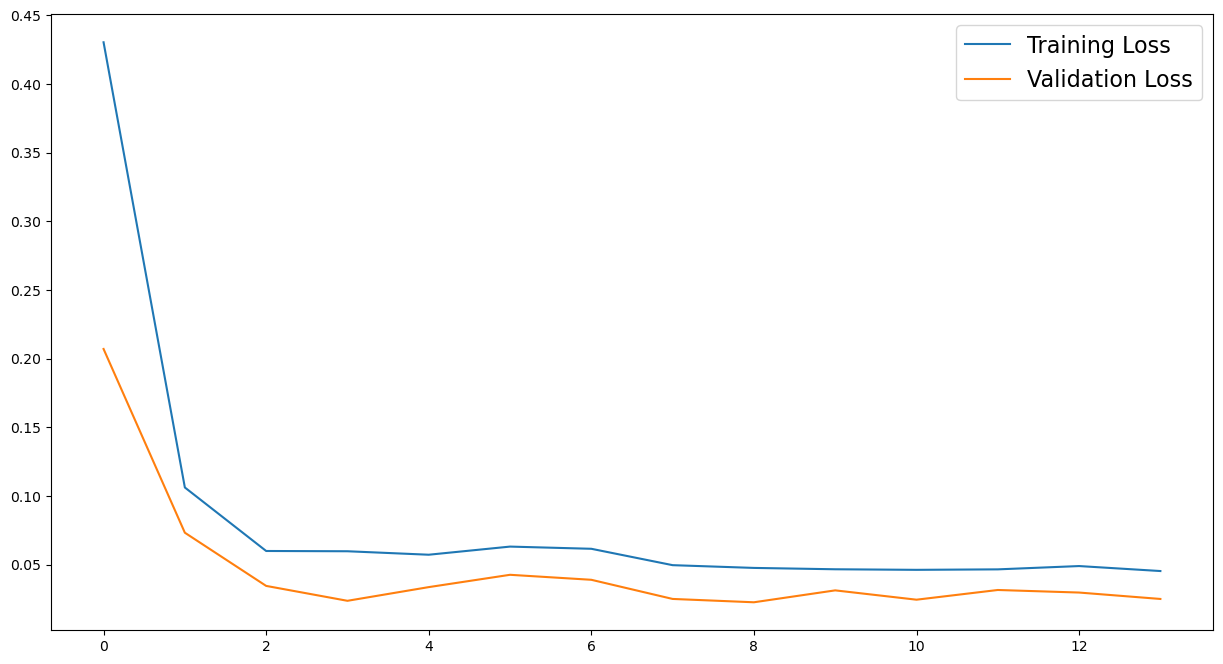

In [9]:
# Learning Curves
plt.figure(figsize=(15, 8))

plt.plot(np.arange(0, early.stopped_epoch + 1), history.history['loss'], label='Training Loss')
plt.plot(np.arange(0, early.stopped_epoch + 1), history.history['val_loss'], label='Validation Loss')

plt.legend(fontsize=16)
plt.show()

In [10]:
y_pred = model.predict(X_test)

3/3 [==============================] - 0s 24ms/step


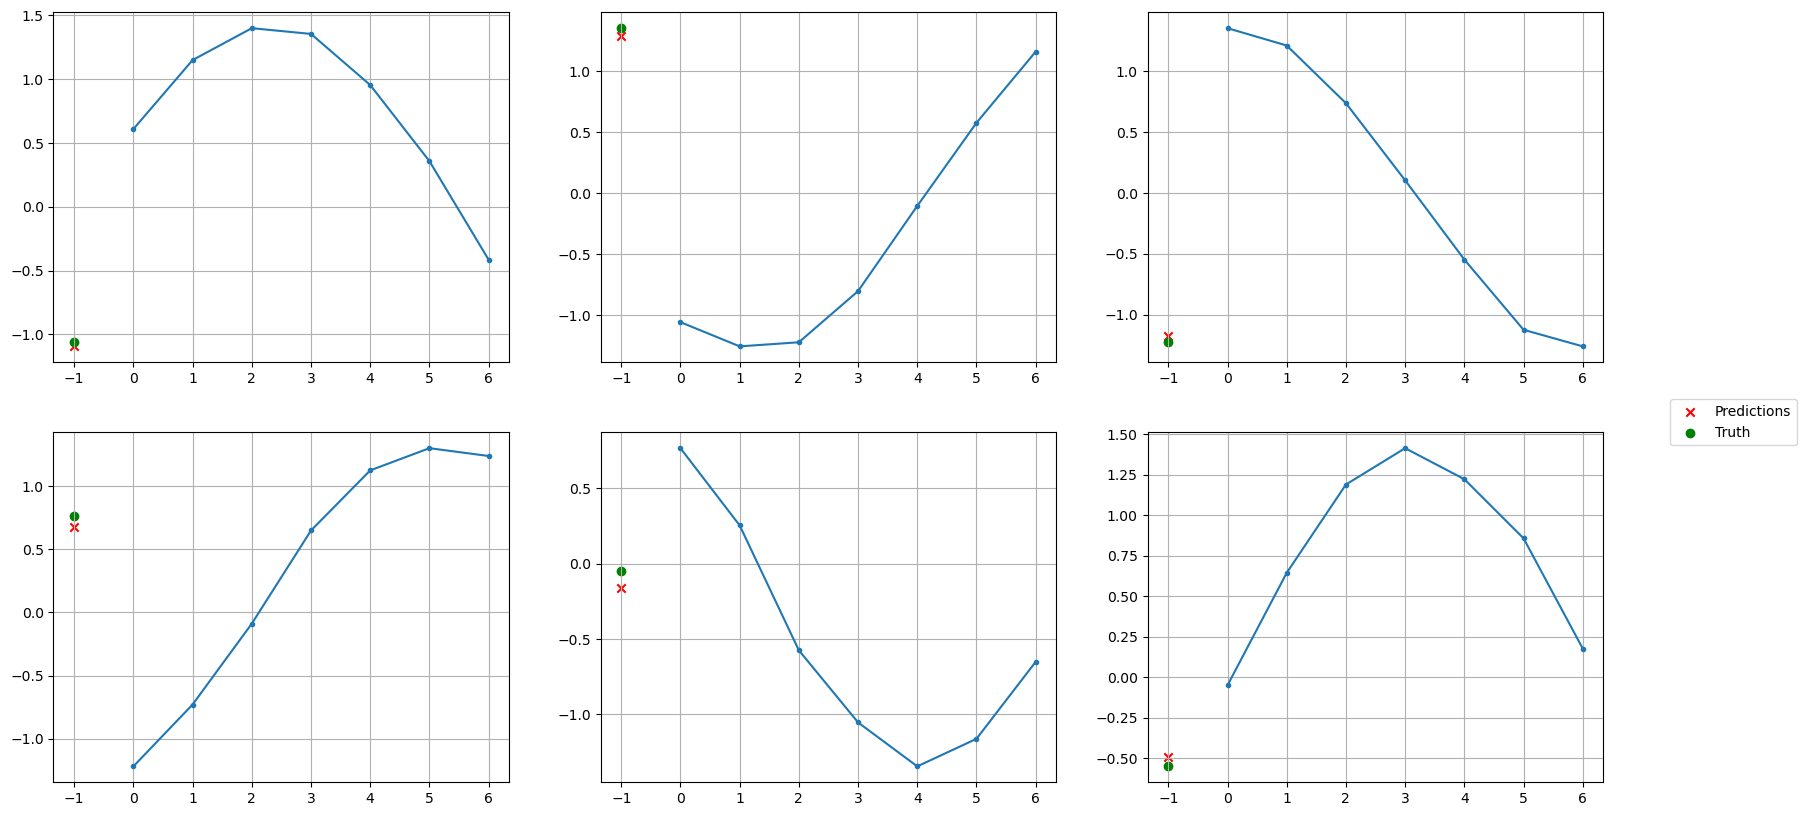

In [11]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
for i, ax in enumerate(np.ravel(axs)):
    ax.plot(X_test[i, :], ".-")
    ax.scatter(np.array([-1]), y_pred[i], c='r', marker='x', label='Predictions')
    ax.scatter(np.array([-1]), y_test[i], c='g', marker='o', label='Truth')
    ax.grid()
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(1, 0.5))
plt.show()

In [12]:
print(f"Benchmark MSE : {mean_squared_error(y_pred, y_test):.4f}")

Benchmark MSE : 0.0576


# Part Two (Training On CNN)
The Corals DataSet
The Brain Tumor DataSet


In [13]:
image_data = []
tumor_directory = 'data/Brain_Tumor/yes'
not_tumor_directory = 'data/Brain_Tumor/no'

directories = [tumor_directory, not_tumor_directory]

for directory in directories:
    for filename in os.listdir(directory):
        if filename.lower().endswith((".jpg", ".jpeg", ".png")):
            img_gray_scale = ImageOps.grayscale(Image.open(os.path.join(directory, filename)))
            img_resized = img_gray_scale.resize((128, 128), Image.Resampling.LANCZOS)
            img_data = pd.DataFrame(np.array(img_resized).reshape(-1)).T
            img_data['status'] = 1 if directory == tumor_directory else 0
            image_data.append(img_data)

all_image = pd.concat(image_data)
all_image.reset_index(drop=True, inplace=True)

all_image

,0,1,2,3,4,5,6,7,8,9,...,16375,16376,16377,16378,16379,16380,16381,16382,16383,status
0,0,1,2,2,2,1,0,1,2,2,...,5,3,4,3,22,20,16,6,25,1
1,6,6,6,6,6,6,6,6,6,6,...,13,13,14,14,14,14,14,14,14,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,7,8,8,6,5,6,6,6,5,6,...,9,10,10,11,11,16,27,29,28,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,7,10,9,6,7,7,9,10,7,8,...,8,8,8,8,8,8,8,8,7,0
249,6,14,13,12,11,15,13,13,15,16,...,14,15,15,13,14,13,11,11,13,0
250,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
251,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


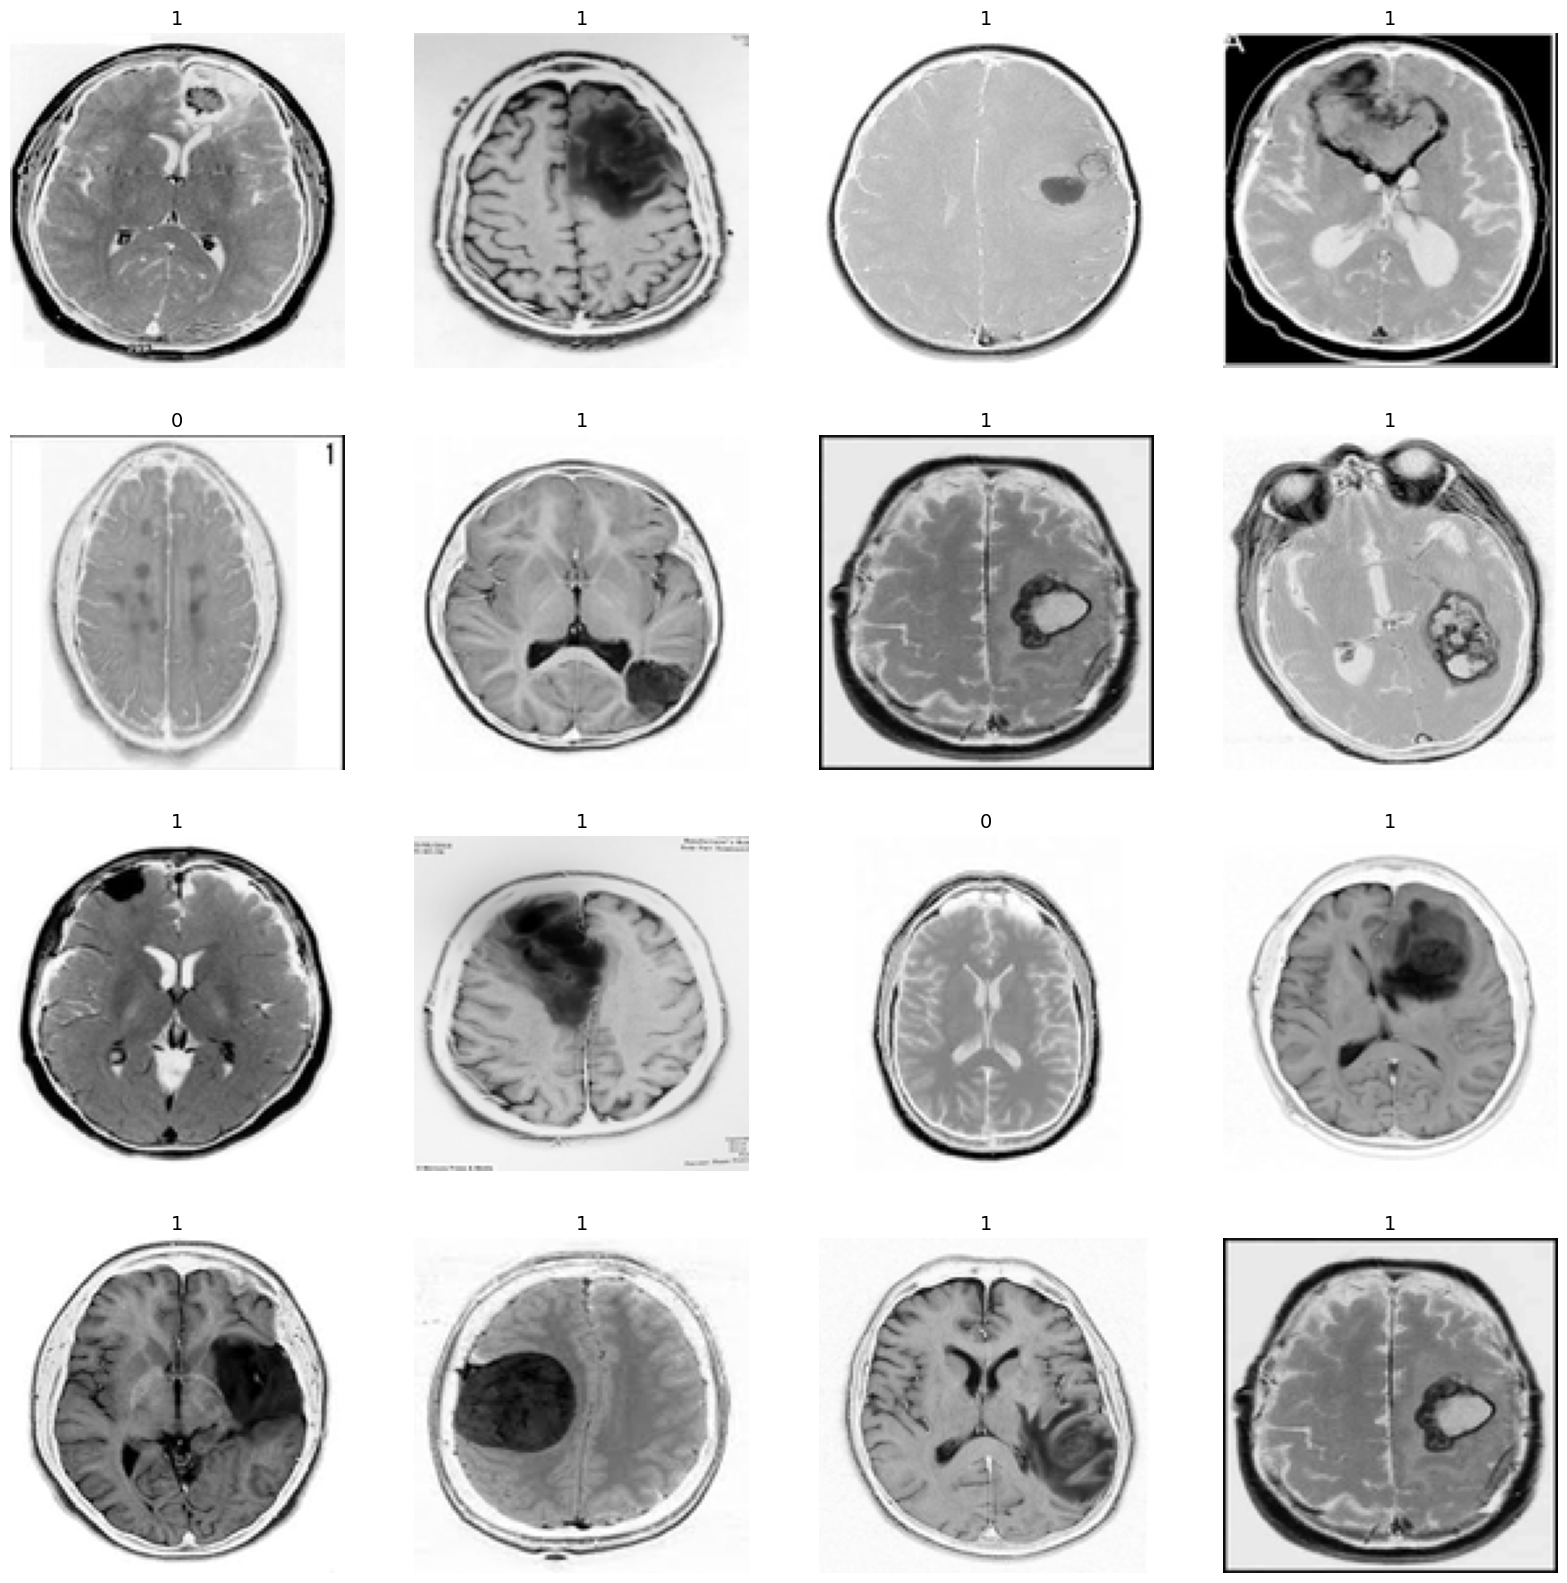

In [14]:
# Validate input!
fig, axs = plt.subplots(4, 4, figsize=(20, 20))

sample = all_image.sample(n=16)
imgs = sample.iloc[:, :-1].to_numpy().astype(np.int64)
labels = sample.iloc[:, -1].to_numpy()

for img, label, ax in zip(imgs, labels, axs.flatten()):
    ax.imshow(img.reshape(128, 128), cmap='binary')
    ax.set_title(label, fontsize=14)
    ax.axis('off')

plt.show()


In [15]:
X = all_image.copy()
y = X.pop('status')

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.1 / (1 - 0.3),
                                                  random_state=42)

In [17]:
# Normalize X
X_train /= 255
X_val /= 255
X_test /= 255

X_train = X_train.to_numpy().reshape(-1, 128, 128, 1)
X_val = X_val.to_numpy().reshape(-1, 128, 128, 1)
X_test = X_test.to_numpy().reshape(-1, 128, 128, 1)

In [18]:
reset_seeds()
tf.keras.backend.clear_session()

model_cnn = tf.keras.Sequential([
    tf.keras.Input(shape=(128, 128, 1)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 127008)            0         
                                                                 
 dense (Dense)               (None, 1)                 127009    
                                                                 
Total params: 127,329
Trainable params: 127,329
Non-trainable params: 0
_________________________________________________________________


In [19]:
early = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
batch_size = 32
epochs = 10

model_cnn.compile(optimizer= tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])

history = model_cnn.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val),
                        callbacks=[early])
model_cnn.evaluate(X_test, y_test)

Epoch 1/10
5/5 [==============================] - 1s 177ms/step - loss: 0.7568 - accuracy: 0.6490 - val_loss: 0.6607 - val_accuracy: 0.6154
Epoch 2/10
5/5 [==============================] - 1s 130ms/step - loss: 0.5016 - accuracy: 0.7682 - val_loss: 0.5031 - val_accuracy: 0.8077
Epoch 3/10
5/5 [==============================] - 1s 121ms/step - loss: 0.4404 - accuracy: 0.8212 - val_loss: 0.4440 - val_accuracy: 0.8077
Epoch 4/10
5/5 [==============================] - 1s 132ms/step - loss: 0.3394 - accuracy: 0.8344 - val_loss: 0.4029 - val_accuracy: 0.8462
Epoch 5/10
5/5 [==============================] - 1s 135ms/step - loss: 0.2867 - accuracy: 0.8874 - val_loss: 0.3733 - val_accuracy: 0.8462
Epoch 6/10
5/5 [==============================] - 1s 129ms/step - loss: 0.2361 - accuracy: 0.9139 - val_loss: 0.3493 - val_accuracy: 0.8077
Epoch 7/10
5/5 [==============================] - 1s 159ms/step - loss: 0.1921 - accuracy: 0.9272 - val_loss: 0.3353 - val_accuracy: 0.8462
Epoch 8/10
5/5 [====

[0.6143810749053955, 0.8157894611358643]

In [20]:
model.save('./model/tumor')

2023-06-22 12:19:29.864834: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,1]
	 [[{{node inputs}}]]
2023-06-22 12:19:29.872372: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,1]
	 [[{{node inputs}}]]
2023-06-22 12:19:29.942811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,32]
	 [[{{node inputs}}]]
2023-06-22 12:1

INFO:tensorflow:Assets written to: ./model/tumor/assets


INFO:tensorflow:Assets written to: ./model/tumor/assets


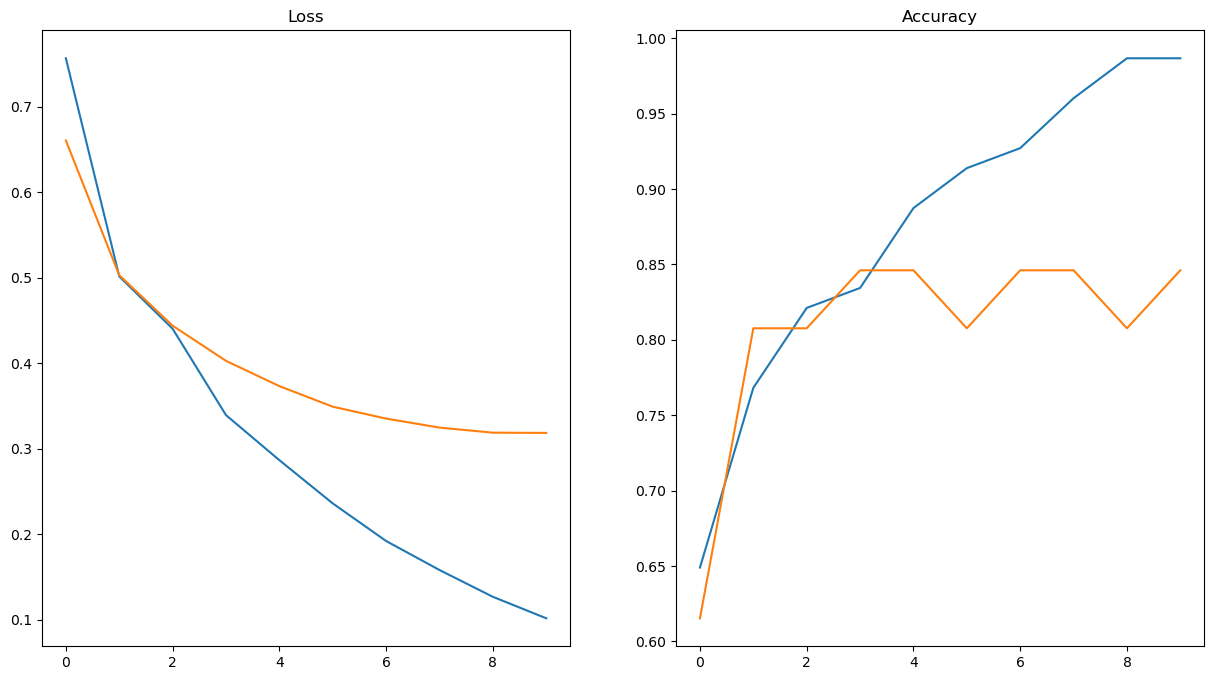

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8))

axs[0].plot(history.history['loss'], label='loss')
axs[0].plot(history.history['val_loss'], label='val loss')
axs[0].set_title('Loss')
axs[1].plot(history.history['accuracy'], label='accuracy')
axs[1].plot(history.history['val_accuracy'], label='val accuracy')
axs[1].set_title('Accuracy')

plt.show()

## Check With Images is it working or No

In [22]:
tumor_directory = 'data/Brain_Tumor/yes'

img_gray_scale = ImageOps.grayscale(Image.open(os.path.join(tumor_directory, 'Y1.jpg')))
img_resized = img_gray_scale.resize((128, 128), Image.Resampling.LANCZOS)
img_data = pd.DataFrame(np.array(img_resized).reshape(-1)).T
img_data /= 255
test = img_data.to_numpy().reshape(-1, 128, 128, 1)
y_predict = model_cnn.predict(test)
y_predict

1/1 [==============================] - 0s 37ms/step


array([[0.98064524]], dtype=float32)

In [23]:
not_tumor_directory = 'data/Brain_Tumor/no'

img_gray_scale = ImageOps.grayscale(Image.open(os.path.join(not_tumor_directory, '1 no.jpeg')))
img_resized = img_gray_scale.resize((128, 128), Image.Resampling.LANCZOS)
img_data = pd.DataFrame(np.array(img_resized).reshape(-1)).T
img_data /= 255
test = img_data.to_numpy().reshape(-1, 128, 128, 1)
y_predict = model_cnn.predict(test)
y_predict

1/1 [==============================] - 0s 79ms/step


array([[0.0138259]], dtype=float32)